In [1]:
pip install scikit-fuzzy


In [2]:
pip install paho-mqtt

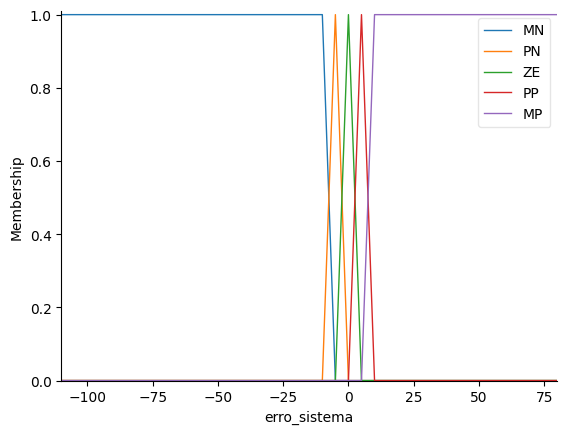

In [3]:
import numpy as np
import skfuzzy as fuzz
import paho.mqtt.client as mqtt
from skfuzzy import control as ctrl
import time

sp=80
velatual=10
erroatual=0

def on_message(client, userdata, message):
  global sp
  global velatual
  if message.topic == "topico_set_point":
    sp = float(message.payload.decode())
  if message.topic == "topico_set_velocidade":
    velatual = float(message.payload.decode())
  print(f'Tópico: {message.topic}')
  print(f'Menssagem: {message.payload.decode()}')


mqttBroker ="test.mosquitto.org"
mqttPort = 1883
client = mqtt.Client("c213Inatelsbm")
client.on_message = on_message
client.connect(mqttBroker, mqttPort)
client.subscribe("topico_set_point")
client.subscribe("topico_set_velocidade")
client.loop_start()

# New Antecedent/Consequent objects hold universe variables and membership
# functions


erro_sistema = ctrl.Antecedent(np.arange(-110, 81, 1), 'erro_sistema')

# Custom membership functions can be built interactively with a familiar,

erro_sistema['MN'] = fuzz.trapmf(erro_sistema.universe, [-110, -110, -10, -5])
erro_sistema['PN'] = fuzz.trimf(erro_sistema.universe, [-10,-5,0])
erro_sistema['ZE'] = fuzz.trimf(erro_sistema.universe, [-5, 0, 5])
erro_sistema['PP'] = fuzz.trimf(erro_sistema.universe, [0, 5, 10])
erro_sistema['MP'] = fuzz.trapmf(erro_sistema.universe,[5, 10, 80, 80])

# gerando o grafico da entrada de erro do sistema
#valores -10 e -5 são valores para gerar o espaçamento dos graficos
erro_sistema.view()



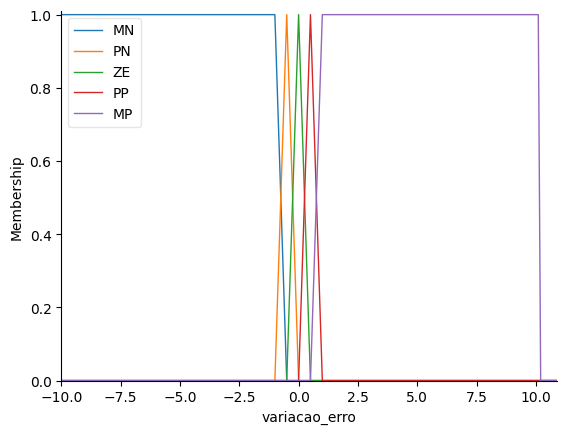

In [4]:
#calculando o delta erro
# erro =   o que voce tem - o que quer
variacao_erro = ctrl.Antecedent(np.arange(-10, 11, 0.1), 'variacao_erro')

variacao_erro['MN'] = fuzz.trapmf(variacao_erro.universe, [-10.1, -10.1, -1,-0.5])
variacao_erro['PN'] = fuzz.trimf(variacao_erro.universe, [-1,-0.5,0])
variacao_erro['ZE'] = fuzz.trimf(variacao_erro.universe, [-0.5, 0, 0.5])
variacao_erro['PP'] = fuzz.trimf(variacao_erro.universe, [0, 0.5, 1])
variacao_erro['MP'] = fuzz.trapmf(variacao_erro.universe,[0.5, 1, 10.1,10.1])
# You can see how these look with .view()
# gerando o grafico da entrada de erro do sistema
#valores -10 e -5 são valores para gerar o espaçamento dos graficos
variacao_erro.view()

#PN e PP não aparecem pelo valor muito pequeno
#os valores disposição do grafico variam de 10% a 5%


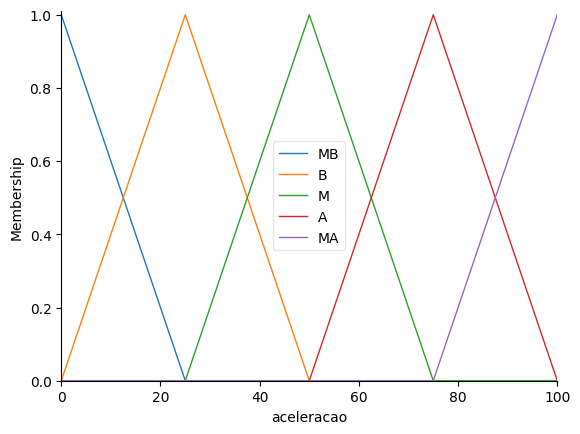

In [5]:
aceleracao = ctrl.Consequent(np.arange(0, 101, 1), 'aceleracao')
# utiliza somente triangular, pois nao estabiliza nas extremidades
aceleracao['MB'] = fuzz.trimf(aceleracao.universe, [0,0,25])
aceleracao['B'] = fuzz.trimf(aceleracao.universe, [0,25,50])
aceleracao['M'] = fuzz.trimf(aceleracao.universe, [25, 50, 75])
aceleracao['A'] = fuzz.trimf(aceleracao.universe, [50, 75, 100])
aceleracao['MA'] = fuzz.trimf(aceleracao.universe, [75, 100, 100])
aceleracao.view()

In [6]:
regra1 = ctrl.Rule(erro_sistema['MN']& variacao_erro['MN'], aceleracao['MA'])
regra2 = ctrl.Rule(erro_sistema['PN']& variacao_erro['MN'], aceleracao['MA'])
regra3 = ctrl.Rule(erro_sistema['ZE']& variacao_erro['MN'], aceleracao['M'])
regra4 = ctrl.Rule(erro_sistema['PP']& variacao_erro['MN'], aceleracao['M'])
regra5 = ctrl.Rule(erro_sistema['MP']& variacao_erro['MN'], aceleracao['M'])
regra6 = ctrl.Rule(erro_sistema['MN']& variacao_erro['PN'], aceleracao['MA'])
regra7 = ctrl.Rule(erro_sistema['PN']& variacao_erro['PN'], aceleracao['A'])
regra8 = ctrl.Rule(erro_sistema['ZE']& variacao_erro['PN'], aceleracao['A'])
regra9 = ctrl.Rule(erro_sistema['PP']& variacao_erro['PN'], aceleracao['B'])
regra10 = ctrl.Rule(erro_sistema['MP']& variacao_erro['PN'], aceleracao['B'])
regra11 = ctrl.Rule(erro_sistema['MN']& variacao_erro['ZE'], aceleracao['MA'])
regra12 = ctrl.Rule(erro_sistema['PN']& variacao_erro['ZE'], aceleracao['MA'])
regra13 = ctrl.Rule(erro_sistema['ZE']& variacao_erro['ZE'], aceleracao['M'])
regra14 = ctrl.Rule(erro_sistema['PP']& variacao_erro['ZE'], aceleracao['M'])
regra15 = ctrl.Rule(erro_sistema['MP']& variacao_erro['ZE'], aceleracao['M'])
regra16 = ctrl.Rule(erro_sistema['MN']& variacao_erro['PP'], aceleracao['A'])
regra17 = ctrl.Rule(erro_sistema['PN']& variacao_erro['PP'], aceleracao['MA'])
regra18 = ctrl.Rule(erro_sistema['ZE']& variacao_erro['PP'], aceleracao['M'])
regra19 = ctrl.Rule(erro_sistema['PP']& variacao_erro['PP'], aceleracao['M'])
regra20 = ctrl.Rule(erro_sistema['MP']& variacao_erro['PP'], aceleracao['B'])
regra21 = ctrl.Rule(erro_sistema['MN']& variacao_erro['MP'], aceleracao['A'])
regra22 = ctrl.Rule(erro_sistema['PN']& variacao_erro['MP'], aceleracao['A'])
regra23 = ctrl.Rule(erro_sistema['ZE']& variacao_erro['MP'], aceleracao['A'])
regra24 = ctrl.Rule(erro_sistema['PP']& variacao_erro['MP'], aceleracao['M'])
regra25 = ctrl.Rule(erro_sistema['MP']& variacao_erro['MP'], aceleracao['MB'])

In [7]:
aceleracao_ctrl = ctrl.ControlSystem([regra1, regra2, regra3,regra4,regra5,regra6, regra7, regra8,regra9,regra10,regra11, regra12, regra13,regra14,regra15,regra16, regra17, regra18,regra19,regra20,regra21, regra22, regra23,regra24,regra25])
potencia = ctrl.ControlSystemSimulation(aceleracao_ctrl)

In [8]:
while True:
  erroanterior=erroatual
  erroatual=velatual-sp
  varerroTemp=erroatual-erroanterior
  potencia.input['erro_sistema'] =erroatual
  potencia.input['variacao_erro'] =varerroTemp
  potencia.compute()
  i=0
  while (i < 10):
    velatual=velatual * 0.9954 + potencia.output['aceleracao'] * 0.007563
    time.sleep(0.2)
    i += 1
  print(f'Velocidade atual: {velatual}')
  client.publish("topico_point", sp)
  client.publish("topico_velocidade", velatual)
  client.publish("topico_erro", erroatual)

Velocidade atual: 16.340394477770555
Velocidade atual: 21.160369514440813
Velocidade atual: 25.76315943151695
Velocidade atual: 30.158550457312238
Velocidade atual: 34.35588785869296
Velocidade atual: 38.36409581053083
Velocidade atual: 42.19169636985004
Velocidade atual: 45.84682759501094
Velocidade atual: 49.337260848454285
Velocidade atual: 52.67041731979461
Velocidade atual: 55.853383804393
Velocidade atual: 58.892927770957115
Velocidade atual: 61.795511750204405
Velocidade atual: 64.56730707518092
Velocidade atual: 67.21420700244984
Velocidade atual: 69.74183924204736
Velocidade atual: 72.15557792284622
Velocidade atual: 74.46055501876756
Velocidade atual: 76.66167126013455
Velocidade atual: 78.76360655336697
Velocidade atual: 80.77082993117102
Velocidade atual: 82.32808461102923
Velocidade atual: 83.29962559875591
Velocidade atual: 83.93459689058844
Velocidade atual: 84.33917699897668
Velocidade atual: 84.24308086068989
Velocidade atual: 84.07452009608161
Velocidade atual: 83.742

KeyboardInterrupt: ignored